In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

掩蔽softmax操作

掩蔽softmax（masked softmax）操作是一种在处理序列数据时的特殊softmax操作，它允许我们在计算softmax时忽略某些无效的或不相关的元素。这种操作对于自然语言处理等应用中特别有用，因为在这些应用中，我们常常会处理变长的序列，并且需要对序列进行填充以使它们具有相同的长度。

掩蔽softmax操作的目的

在处理小批量序列数据时，我们常常需要将不同长度的序列填充到相同的长度。在这种情况下，填充的部分（通常是一些特殊的填充标记）是不应被计算在内的。掩蔽softmax操作的主要目的是在计算注意力权重时，只对有效的序列部分进行计算，而忽略填充部分。


In [2]:
def masked_softmax(X, valid_lens):
    '''
    通过再最后一个轴上掩蔽元素来执行softmax操作
    X：3D张量，valid_lens: 1D或2D张量
    
    X: 一个形状为 (batch_size, num_steps, dim) 的3D张量，表示要进行softmax操作的输入。
    valid_lens: 一个1D或2D张量，表示每个序列的有效长度。
    
    首先检查 valid_lens 是否为 None，如果是，则直接对 X 的最后一个维度执行softmax操作。
    '''
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
        '''
        如果 valid_lens 不是 None，则需要对其进行处理：
        获取输入 X 的形状 shape。

        如果 valid_lens 是1D张量，则将其重复以匹配 X 的第二个维度（即 num_steps）。

            原因：valid_lens 是1D张量时，意味着每个样本只有一个有效长度值，
                这个值适用于该样本中的所有序列步长（num_steps）。
            操作：torch.repeat_interleave(valid_lens, shape[1]) 
                这一步将每个有效长度值重复 num_steps 次，使其与每个样本的序列步长对齐。
            目的：确保每个样本中的每个序列步长都能正确应用对应的有效长度，
                从而在掩蔽操作时能够准确识别哪些位置是有效的，哪些位置需要被掩蔽。

        如果 valid_lens 是2D张量，则将其展平为1D张量。
            原因：valid_lens 是2D张量时，意味着对于每个样本的每个序列步长，
                都有一个独立的有效长度值。
            操作：valid_lens.reshape(-1) 这一步将 valid_lens 展平为1D张量，
                使其可以直接应用于掩蔽操作。
            目的：确保每个样本中的每个序列步长都能独立应用对应的有效长度，
                从而在掩蔽操作时能够更精确地处理不同样本和不同序列步长之间的差异。

        '''
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
            print("valid_lens:",valid_lens)
        '''
        将 X 重塑为二维张量，并调用 d2l.sequence_mask 函数，
        使用一个非常大的负值（如 -1e6）来掩蔽超出有效长度的位置。
        
        将掩蔽后的 X 重塑回原始形状，并对最后一个维度执行softmax操作。
        '''
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(
            X.reshape(-1, shape[-1]),
            valid_lens,
            value=-1e6
        )
        
        return nn.functional.softmax(
            X.reshape(shape), dim=-1
        )

In [3]:

'''
对于第一个样本，只有前两个元素是有效的，其余元素被掩蔽为0；对于第二个样本，前三个元素是有效的。
'''
masked_softmax(
    torch.rand(2, 2, 4),
    torch.tensor([2, 3])
)

tensor([[[0.4272, 0.5728, 0.0000, 0.0000],
         [0.4742, 0.5258, 0.0000, 0.0000]],

        [[0.3174, 0.3130, 0.3695, 0.0000],
         [0.2763, 0.4286, 0.2951, 0.0000]]])

In [4]:
'''
每个样本的每一行都有各自的有效长度，超出有效长度的元素被掩蔽为0。
'''
masked_softmax(
    torch.rand(2, 2, 4),
    torch.tensor([[1, 3], [2, 4]])
)

valid_lens: tensor([1, 3, 2, 4])


tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4163, 0.2976, 0.2861, 0.0000]],

        [[0.5429, 0.4571, 0.0000, 0.0000],
         [0.2293, 0.1800, 0.4031, 0.1877]]])

---

加性注意力

加性注意力（Additive Attention），又称Bahdanau注意力，是一种用于处理查询和键具有不同长度的注意力机制。它通过将查询和键进行线性变换后相加，然后通过非线性激活函数来计算注意力得分。加性注意力的实现包含了一些可学习的参数，这些参数通过训练进行优化，以提高注意力机制的表现。


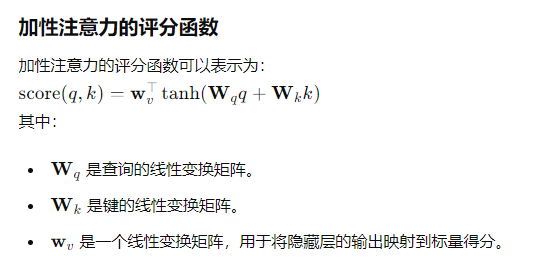


In [5]:
class AdditiveAttention(nn.Module):
    '''
    - `self.W_k`: 用于对键进行线性变换的权重矩阵。
    - `self.W_q`: 用于对查询进行线性变换的权重矩阵。
    - `self.W_v`: 用于将隐藏层的输出映射到标量得分的权重矩阵。
    - `self.dropout`: 用于在训练过程中随机丢弃一部分神经元，以防止过拟合。
    '''
    # 加性注意力
    def __init__(
        self, key_size, query_size, num_hiddens, dropout, **kwargs
    ):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.W_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(
        self, queries, keys, values, valid_lens
    ):
        '''
        - 对查询和键进行线性变换。
        - 将查询和键的结果进行扩展维度后相加，然后应用 `tanh` 激活函数。
        - 将结果通过 `self.w_v` 进行线性变换并移除最后一个维度，得到注意力得分 `scores`。
        - 通过 `masked_softmax` 函数计算注意力权重 `self.attention_weights`。
        - 使用 `torch.bmm` 函数计算注意力权重与值的加权和，并返回结果。
        
        queries.shape: torch.Size([2, 1, 20])
        keys.shape: torch.Size([2, 10, 2])
        '''
        queries, keys = self.W_q(queries), self.W_k(keys)
        '''
        queries.shape: torch.Size([2, 1, 8])
        keys.shape: torch.Size([2, 10, 8])
        '''
        
        '''
        在维度扩展后
        queries的形状：(batch_size, 查询的个数，1，num_hidden)
        key的形状：(batch_size, 查询的个数, "键-值"对的个数)
        使用广播方式进行求和
        '''
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        '''
        queries.unsqueeze(2).shape: torch.Size([2, 1, 1, 8])
        keys.unsqueeze(1).shape: torch.Size([2, 1, 10, 8])
        features.shape: torch.Size([2, 1, 10, 8])
        '''
        features = torch.tanh(features)
        '''
        features.shape: torch.Size([2, 1, 10, 8])
        '''
        
        '''
        self.W_v仅有一个输出，因此从形状中移除最后那个维度。
        scores的形状：(batch_size, 查询的个数， '键-值'对的个数)
        '''
        scores = self.W_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        '''
        value的形状：(batch_size,  '键-值'对的个数, values)
        '''
        return torch.bmm(
            self.dropout(
                self.attention_weights
            ), values
        )
    
'''
加性注意力通过将查询和键进行线性变换后相加，然后通过非线性激活函数计算得分，
并通过softmax操作得到注意力权重。最终，通过注意力权重对值进行加权和，
得到注意力汇聚的输出。这种机制能够有效地处理查询和键具有不同长度的情况，
并且通过可学习的参数进行优化，提高模型的表现。
'''

'\n加性注意力通过将查询和键进行线性变换后相加，然后通过非线性激活函数计算得分，\n并通过softmax操作得到注意力权重。最终，通过注意力权重对值进行加权和，\n得到注意力汇聚的输出。这种机制能够有效地处理查询和键具有不同长度的情况，\n并且通过可学习的参数进行优化，提高模型的表现。\n'

### 代码
```python
features = queries.unsqueeze(2) + keys.unsqueeze(1)
```

### 背景
在加性注意力中，我们需要将查询和键进行线性变换后相加，然后通过非线性激活函数来计算注意力得分。为了使查询和键可以进行相加，我们需要调整它们的维度，使它们能够进行广播（broadcasting）相加。

### 查询和键的形状
假设：
- `queries` 的形状为 `(batch_size, num_queries, query_dim)`
- `keys` 的形状为 `(batch_size, num_key_value_pairs, key_dim)`

经过线性变换后：
- `queries` 的形状变为 `(batch_size, num_queries, num_hiddens)`
- `keys` 的形状变为 `(batch_size, num_key_value_pairs, num_hiddens)`

### unsqueeze 操作
- `queries.unsqueeze(2)` 会在 `queries` 的第2维（索引从0开始）插入一个新的维度，其形状变为 `(batch_size, num_queries, 1, num_hiddens)`
- `keys.unsqueeze(1)` 会在 `keys` 的第1维（索引从0开始）插入一个新的维度，其形状变为 `(batch_size, 1, num_key_value_pairs, num_hiddens)`

### 广播相加
在进行了 `unsqueeze` 操作后，`queries` 和 `keys` 的形状分别为：
- `queries.unsqueeze(2)`：`(batch_size, num_queries, 1, num_hiddens)`
- `keys.unsqueeze(1)`：`(batch_size, 1, num_key_value_pairs, num_hiddens)`

这两者可以进行广播相加。广播相加的结果 `features` 的形状为：
- `(batch_size, num_queries, num_key_value_pairs, num_hiddens)`

### 总结
通过 `unsqueeze` 操作，查询和键的维度被调整，使得它们能够进行广播相加。这样，我们就可以将查询和键在每个隐藏单元上相加，得到一个新的张量 `features`，其形状为 `(batch_size, num_queries, num_key_value_pairs, num_hiddens)`。这个张量随后会通过 `tanh` 激活函数，再进行线性变换，得到注意力得分。

### 示例
假设 `batch_size=2`, `num_queries=1`, `num_key_value_pairs=10`, `num_hiddens=8`，那么：

```python
queries = torch.randn(2, 1, 8)
keys = torch.randn(2, 10, 8)

queries_unsqueezed = queries.unsqueeze(2)  # 形状: (2, 1, 1, 8)
keys_unsqueezed = keys.unsqueeze(1)        # 形状: (2, 1, 10, 8)

features = queries_unsqueezed + keys_unsqueezed  # 形状: (2, 1, 10, 8)
```

在这个例子中，`features` 将包含查询和键的广播相加结果，每个查询和键对之间的每个隐藏单元值相加。

In [6]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
'''
value的小批量，两个值矩阵是相同的
'''
values = torch.arange(
    40, dtype=torch.float32
).reshape(1, 10, 4).repeat(2, 1, 1)

valid_lens = torch.tensor([2, 6])

### 1. 生成查询、键和值的张量

```python
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
```

- `queries` 是一个正态分布随机生成的张量，形状为 `(2, 1, 20)`，表示有2个样本，每个样本有1个查询向量，每个查询向量的维度为20。
- `keys` 是一个全是1的张量，形状为 `(2, 10, 2)`，表示有2个样本，每个样本有10个键向量，每个键向量的维度为2。

### 2. 生成值的张量

```python
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
```

- `values` 是一个由0到39的浮点数构成的张量，首先被形状化为 `(1, 10, 4)`，然后被重复以匹配批量大小。
- 最终的 `values` 形状为 `(2, 10, 4)`，表示有2个样本，每个样本有10个值向量，每个值向量的维度为4。

### 3. 有效长度

```python
valid_lens = torch.tensor([2, 6])
```

- `valid_lens` 是一个张量，表示每个样本的有效键长度。
- 第一个样本的有效长度为2，第二个样本的有效长度为6。这意味着在计算注意力时，只会考虑前2个和前6个键，超出部分将被掩蔽。

### 4. 初始化加性注意力机制

```python
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
```

- `key_size=2`：键的维度为2。
- `query_size=20`：查询的维度为20。
- `num_hiddens=8`：隐藏层的单元数（注意力机制内部的维度）为8。
- `dropout=0.1`：在计算注意力权重时使用的dropout率为0.1，以防止过拟合。

### 5. 计算注意力

```python
attention.eval()
output = attention(queries, keys, values, valid_lens)
print(output)
```

- 这部分代码在评估模式下运行加性注意力机制，并计算注意力汇聚的输出。
- `queries` 的形状为 `(2, 1, 20)`。
- `keys` 的形状为 `(2, 10, 2)`。
- `values` 的形状为 `(2, 10, 4)`。
- `valid_lens` 表示每个样本的有效键长度。

### 6. 结果

```python
tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],
        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)
```

- 输出的张量形状为 `(2, 1, 4)`，表示2个样本，每个样本1个查询向量，每个查询向量的维度为4。
- 输出表示每个查询向量和有效键对应的值的加权和。因为每个键都是相同的（值为1），所以注意力权重是均匀分布的，由 `valid_lens` 指定。

### 注意力权重可视化

```python
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')
```

- 通过可视化注意力权重，可以看到每个查询向量对每个键向量的注意力权重分布。
- 注意力权重形状为 `(2, 1, 10)`，在可视化时将其调整为 `(1, 1, 2, 10)` 以便于显示。

### 总结

- 查询 (`queries`) 和键 (`keys`) 被线性变换并相加，然后通过 `tanh` 激活函数计算注意力得分 (`scores`)。
- 使用 `masked_softmax` 计算注意力权重，掩蔽掉无效的键。
- 注意力权重与值 (`values`) 相乘，得到加权和作为输出。

In [7]:
attention = AdditiveAttention(
    key_size=2, query_size=20, num_hiddens=8, dropout=0.1
)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

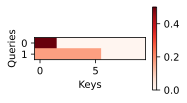

In [8]:
d2l.show_heatmaps(
    attention.attention_weights.reshape((1, 1, 2, 10)),
    xlabel="Keys",
    ylabel="Queries"
)

------
缩放点积注意力

缩放点积注意力（Scaled Dot-Product Attention）是一种计算效率更高的注意力机制。它通过对查询和键进行点积运算，并将结果进行缩放来计算注意力权重。以下是对上述代码和概念的详细解释：

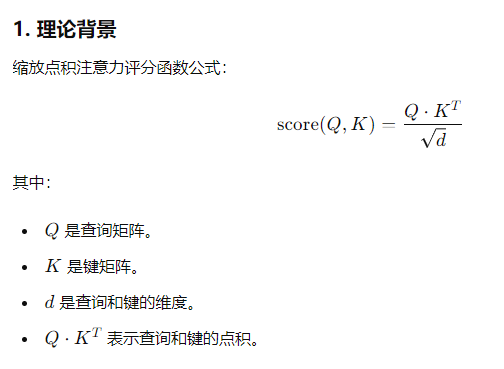

In [9]:
class DotProductAttention(nn.Module):
    #缩放点积注意力
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    '''
    - `dropout`：在计算注意力权重时使用的dropout率，以防止过拟合。
    
    queries的形状：(batch_size, 查询的个数, d)
    keys的形状：(batch_size, "键-值"对的个数, d)
    values的形状：(batch_sizr, "键-值"对的个数, 值的维度)
    valid_lens的形状: (batch_size, )或者(batch_size, 查询的个数)
    '''
    def forward(self, queries, keys, values, valid_lens=None):
        '''
        - `queries` 的形状：(batch_size, num_queries, d)
        - `keys` 的形状：(batch_size, num_key_value_pairs, d)
        - `values` 的形状：(batch_size, num_key_value_pairs, value_dim)
        - `valid_lens` 的形状：(batch_size,) 或者 (batch_size, num_queries)
        
        
        '''
        d = queries.shape[-1]
        '''
        设置transpose_b=True为了交换keys的最后两个维度
        计算点积并缩放
        - `torch.bmm` 进行批量矩阵乘法，`queries` 和 `keys` 的转置相乘，
            然后除以 \(\sqrt{d}\) 进行缩放。

        '''
        scores = torch.bmm(
            queries,
            keys.transpose(1, 2)
        ) / math.sqrt(d)
        '''
        计算注意力权重
        - `masked_softmax` 计算注意力权重，同时掩蔽掉无效的部分。
        '''
        self.attention_weights = masked_softmax(scores, valid_lens)
        '''
        应用注意力权重并进行暂退法
        - 使用注意力权重对 `values` 进行加权和，并应用dropout。
        
        '''
        return torch.bmm(
            self.dropout(self.attention_weights),
            values
        )
        

In [10]:
'''
**生成数据**：
   - `queries`：形状为 `(2, 1, 2)`，表示2个样本，每个样本1个查询向量，查询向量的维度为2。
   - `keys`：形状为 `(2, 10, 2)`，表示2个样本，每个样本10个键向量，键向量的维度为2。
   - `values`：形状为 `(2, 10, 4)`，表示2个样本，每个样本10个值向量，值向量的维度为4。
   - `valid_lens`：有效长度张量，表示每个样本的有效键长度。
'''
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)

'''
**计算注意力输出**：
   - `output` 的形状为 `(2, 1, 4)`，表示2个样本，每个样本1个查询向量的注意力输出，输出维度为4。
'''
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

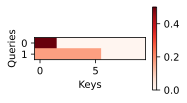

In [11]:
'''
- **缩放点积注意力** 利用点积计算查询和键的相似度，缩放结果以避免随向量长度增长方差过大。
- **masked_softmax** 掩蔽掉无效部分，确保计算仅基于有效键。
- **dropout** 提高模型的泛化能力。
  
这一方法通过点积和缩放操作有效提升了计算效率，同时保证了注意力机制的稳定性和准确性。
'''
d2l.show_heatmaps(
    attention.attention_weights.reshape((1, 1, 2, 10)),
    xlabel="Keys",
    ylabel="Queries"
)